In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 下载MNIST数据集

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST Original',data_home='../datasets/MNIST-data/')
mnist

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X,y = mnist['data'],mnist['target']
X.shape,y.shape

((70000, 784), (70000,))

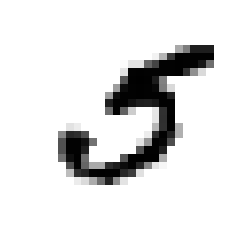

In [4]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = matplotlib.cm.binary,interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
#标签显示为5
y[36000]

5.0

In [6]:
#切分训练集和测试集
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [7]:
#打乱顺序
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index] 

# 训练一个二分类器

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
#使用SGD 默认迭代1000次
from sklearn.linear_model import SGDClassifier
#random_state 确保每次数据一致
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
#预测正确了
sgd_clf.predict([some_digit])

array([ True])

自己实现k折交叉验证,当你自己需要高度控制时很有用

In [11]:
#交叉验证 k折
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3,random_state=42)
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9441
0.95125
0.9579


StratifiedKFold类实现了分层采样,生成的折（fold） 包含了各类相应比例的样例.在每一次迭代，上述代码生成分类器的一个克隆版本，在训练折（training folds） 的克隆版本上进行训练，在测试折（test folds） 上进行预测。然后它计算出被正确预测的数目和输出正确预测的比例。

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.9441 , 0.95125, 0.9579 ])

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.9075 , 0.9086 , 0.91285])

没错，这个笨的分类器也有 90% 的精度。这是因为只有 10% 的图片是数字 5，所以你总是猜测某张图片不是 5，你也会有90%的可能性是对的。  
所以当数据不均衡时，需要使用其他的性能度量指标

## 混淆矩阵

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53001,  1578],
       [ 1357,  4064]], dtype=int64)

混淆矩阵中的每一行表示一个实际的类, 而每一列表示一个预测的类。该矩阵的第一行认为“非5”（反例） 中的 53001 张被正确归类为 “非 5”（他们被称为真反例，true negatives） , 而其余1578 被错误归类为"是 5" （假正例，false positives） 。第二行认为“是 5” （正例） 中的 1357被错误地归类为“非 5”（假反例，false negatives） ，其余 4064 正确分类为 “是 5”类（真正例，true positives） 。一个完美的分类器将只有真反例和真正例，所以混淆矩阵的非零值仅在其主对角线（左上至右下） 

In [32]:
# 准确率和召回率
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.7203119461183978

In [33]:
recall_score(y_train_5,y_train_pred)

0.7496771813318576

当你去观察精度的时候，你的“数字 5 探测器”看起来还不够好。当它声明某张图片是 5 的时候，它只有 72% 的可能性是正确的。而且，它也只检测出“是 5”类图片当中的 74%。

In [82]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7347012564403869

Scikit-Learn 不让你直接设置阈值，但是它给你提供了设置决策分数的方法，这个决策分数可以用来产生预测.  
通过设置阈值，做出你想要的预测。  
调高阈值降低召回率，增加预测值，反之亦然。

In [35]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2415.30076175])

In [37]:
threshold = 0
y_some_digit = (y_scores > threshold)
y_some_digit

array([ True])

In [38]:
threshold = 2500
y_some_digit = (y_scores > threshold)
y_some_digit

array([False])

In [39]:
#指定返回决策分数（decision_function）
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [40]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

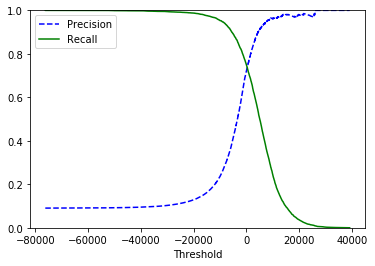

<Figure size 864x720 with 0 Axes>

In [54]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

你也许会好奇为什么准确率曲线比召回率曲线更加起伏不平。原因是准确率有时候会降低，尽管当你提高阈值的时候，通常来说准确率会随之提高  
另一方面，当阈值提高时候，召回率只会降低。这也就说明了为什么召回率的曲线更加平滑

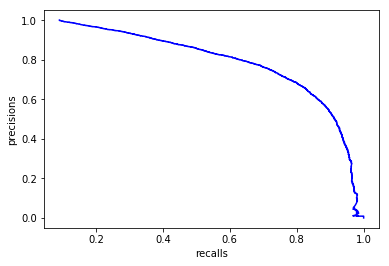

In [59]:
#准确率对召回率的曲线,更容易选择阈值
plt.plot(precisions[:-1],recalls[:-1], "b-", label="Precision")
plt.xlabel("recalls")
plt.ylabel('precisions')
plt.show()

假设决定达到 90% 的准确率。在 5000 附近找到一个阈值

In [63]:
y_train_pred_90 = (y_scores > 5000)
precision_score(y_train_5,y_train_pred_90)

0.911

In [64]:
recall_score(y_train_5,y_train_pred_90)

0.5041505257332596

## ROC曲线(true positive rate)

ROC 曲线是真正例率（true positive rate，另一个名字叫做召回率） 对假正例率（false positive rate, FPR） 的曲线

FPR 是反例被错误分成正例的比率。它等于 1 减去真反例率（true negative rate， TNR） 。  
TNR是反例被正确分类的比率。TNR也叫做特异性。所以 ROC 曲线画出召回率对（1 减特异性） 的曲线

In [66]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

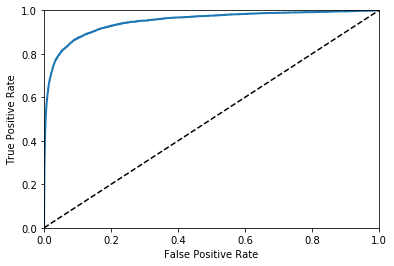

In [67]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

一个比较分类器之间优劣的方法是：测量ROC曲线下的面积（AUC） 。一个完美的分类器的ROC AUC 等于 1，而一个纯随机分类器的 ROC AUC 等于 0.5。

In [70]:
#auc计算  
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9491478936727663

因为 ROC 曲线跟准确率/召回率曲线（或者叫 PR） 很类似，你或许会好奇如何决定使用哪一
个曲线呢？一个笨拙的规则是，优先使用 PR 曲线当正例很少，或者当你关注假正例多于假
反例的时候。其他情况使用 ROC 曲线。举例子，回顾前面的 ROC 曲线和 ROC AUC 数值，
你或许认为这个分类器很棒。但是这几乎全是因为只有少数正例（“是 5”） ，而大部分是反例
（“非 5”） 。相反，PR 曲线清楚显示出这个分类器还有很大的改善空间（PR 曲线应该尽可能
地靠近右上角） 

训练个随机森林和SGD进行比较

In [89]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
#随机森林没有decision_function，只有predict_proba
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [73]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

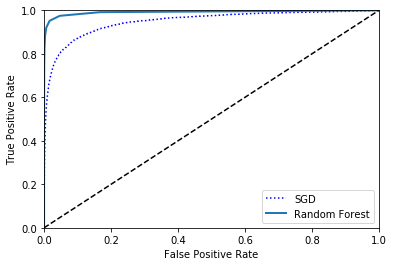

In [75]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

明显可以看出随机森林的ROC曲线比SGD的好很多

In [76]:
roc_auc_score(y_train_5,y_scores_forest)

0.9918395968315556

In [79]:
y_forest_pred = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
precision_score(y_train_5,y_forest_pred)

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9854433171592413

In [81]:
recall_score(y_train_5,y_forest_pred)

0.8242021767201624